In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time
from sklearn.linear_model import LinearRegression

def apply_lowpass_filter(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, high_freq / (0.5 * fs), 'lowpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def apply_highpass_filter(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, high_freq / (0.5 * fs), 'highpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def apply_highpass_filter_1(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    b, a = signal.butter(1, high_freq / (0.5 * fs), 'highpass')
    zi = signal.lfilter_zi(b, a)
    filtered_data[:], _ = signal.lfilter(b, a, data[:], zi=zi*data[0])
    return filtered_data


def apply_bandpass_filter(data, low_freq, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, [low_freq / (0.5 * fs), high_freq / (0.5 * fs)], 'bandpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def rescale_array(array1,array2):
    scaled_array=np.zeros_like(array1)
    for i in range(array1.shape[1]):
        new_min=np.min(array1[:,i])
        new_max=np.max(array1[:,i])
        min_val = np.min(array2[:,i])
        max_val = np.max(array2[:,i])
        scaled_array[:,i] = (array2[:,i] - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    return scaled_array

def rescale_array1(array1,array2):
    scaled_array=np.zeros_like(array1)
    new_min=np.min(array1)
    new_max=np.max(array1)
    min_val = np.min(array2)
    max_val = np.max(array2)
    scaled_array = (array2 - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    return scaled_array

def apply_lowpass_filter_realtime(data_point, b, a, zi):
    start_time = time.time()  # 记录开始时间
    filtered_data_point, zi = signal.lfilter(b, a, [data_point], zi=zi)
    end_time = time.time()  # 记录结束时间
    filter_time = end_time - start_time  # 计算滤波时间
    return filtered_data_point[0], zi, filter_time 

def apply_highpass_filter_realtime(data_point, b, a, zi):
    start_time = time.time()  # 记录开始时间
    filtered_data_point, zi = signal.lfilter(b, a, [data_point], zi=zi)
    end_time = time.time()  # 记录结束时间
    filter_time = end_time - start_time  # 计算滤波时间
    return filtered_data_point[0], zi, filter_time

class CustomLinearRegression:
    def __init__(self):
        self.slope = None
        self.intercept = None

    def fit(self, X, y):
        X = np.column_stack((np.arange(100).reshape(-1, 1), np.ones_like(np.arange(100).reshape(-1, 1)))) # Add column of ones for intercept
        self.coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.slope = self.coefficients[0]
        self.intercept = self.coefficients[1]

    def predict(self, X):
        return (X * self.slope + self.intercept).reshape(-1)
    
class CustomLinearRegression2:
    def __init__(self):
        self.slope = None
        self.intercept = None
    def fit(self, X, y):
        n = len(X)
        sum_x = np.sum(X)
        sum_y = np.sum(y)
        sum_x_squared = np.sum(X ** 2)
        sum_xy = np.sum(X * y)
    
    # 计算斜率和截距
        self.slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x_squared - sum_x ** 2)
        self.intercept = (sum_y - self.slope * sum_x) / n

    def predict(self, X):
        return (X * self.slope + self.intercept).reshape(-1)
    

class LineIntersection:
    def __init__(self):
        pass
    
    def calculate_slope_intercept(self, point1, point2):
        # Calculate the slope and intercept of the line passing through two points
        x1, y1 = point1
        x2, y2 = point2
        
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        
        return slope, intercept
    
    def line_through_point_with_angle(self, position, yaw):
        # Given point
        x0 = position[0]
        y0 = position[1]
        
        # Convert yaw to radians
        yaw_rad = np.radians(yaw)
        
        # Calculate slope
        self.line2_slope = np.tan(yaw_rad + np.pi/2)  # Adding pi/2 because we want angle with x-axis
        self.line2_intercept = y0 - self.line2_slope * x0
    
    def intersection_point(self):
        # Solve the system of equations to find the intersection point
        x_intersect = (self.line2_intercept - self.line1_intercept) / (self.line1_slope - self.line2_slope)
        y_intersect = self.line1_slope * x_intersect + self.line1_intercept
        
        return x_intersect, y_intersect
    
    def distance_between_points(self, point1, point2):
        # Calculate the Euclidean distance between two points
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def calculate_GT(self, point1, point2, position, yaw):
        self.line1_slope, self.line1_intercept = self.calculate_slope_intercept(point1, point2)
        self.line_through_point_with_angle(position, yaw)
        intersection_point = self.intersection_point()
        distance = self.distance_between_points(position, intersection_point)
        GT = (distance - 0.016) * 1000
        return GT

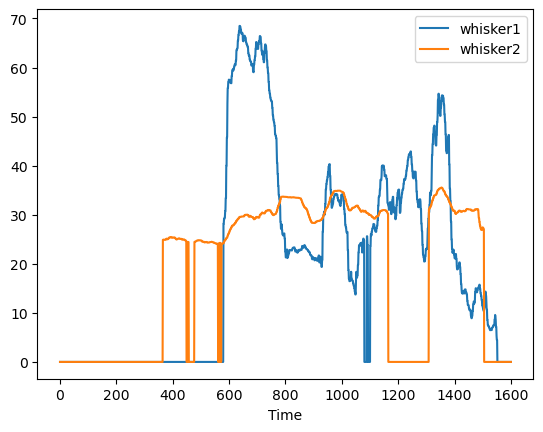

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 读取CSV文件
data = pd.read_csv('whisker_data_MLP30-80_carbon_0.15ms.csv')

# 获取列数据并提取数字部分
whisker1 = data.iloc[:, 1].apply(lambda x: re.search(r'[-+]?\d*\.\d+|\d+', str(x)).group(0)).astype(float)
whisker2 = data.iloc[:, 2].apply(lambda x: re.search(r'[-+]?\d*\.\d+|\d+', str(x)).group(0)).astype(float)

# 绘制图表
plt.plot(whisker1, label="whisker1")
plt.plot(whisker2, label="whisker2")
plt.legend()
plt.xlabel("Time")
plt.show()

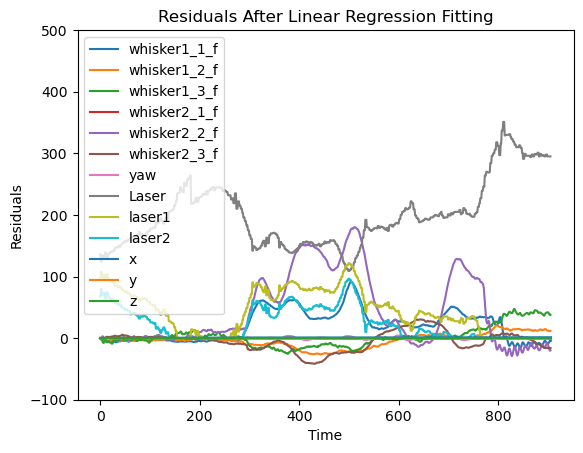

In [3]:
# 1-5
data = pd.read_csv('data/20240422/2024-04-30+15:58:23+.csv')
pressure = data.iloc[2:, 7:13].values
laser = data.iloc[2:, -1].values
yaw = data.iloc[2:, -3].values
position=data.iloc[2:,1:4].values
velocity=data.iloc[2:,4:7].values
laser1=laser+25*np.tan(np.radians(yaw-30))
laser2=laser-25*np.tan(np.radians(yaw-30))
laser1 = np.where(laser1 > 218, 0, 218 - laser1)
laser2 = np.where(laser2 > 218, 0, 218 - laser2)
pitch = data.iloc[2:, -2].values
point1 = [-0.255186, 1.189175]
point2 = [-1.104007, 1.177670]
line_intersection = LineIntersection()
GT = line_intersection.calculate_GT(point1, point2, [position[:,1],position[:,0]], yaw)
# GT=((1.188-position[:,0])/np.cos(np.radians(yaw))-0.016)*1000
GT1=GT+25*np.tan(np.radians(yaw))
GT2=GT-25*np.tan(np.radians(yaw))
GT1 = np.where(GT1 > 218, 0, 218 - GT1)
GT2 = np.where(GT2 > 218, 0, 218 - GT2)
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,1,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
# plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
# plt.plot(GT, label="GT")
# plt.plot(GT1, label="GT1")
# plt.plot(GT2, label="GT2")
plt.plot(laser1, label="laser1")
plt.plot(laser2, label="laser2")
plt.plot(position[:,0], label="x")
plt.plot(position[:,1], label="y")
plt.plot(position[:,2], label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()


new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'Laser1': laser1,
    'Laser2': laser2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2],
    'GT': GT,
    'GT1': GT1,
    'GT2': GT2

})
# new_data.to_csv('dataanalyse/0425/data1.csv', index=False)

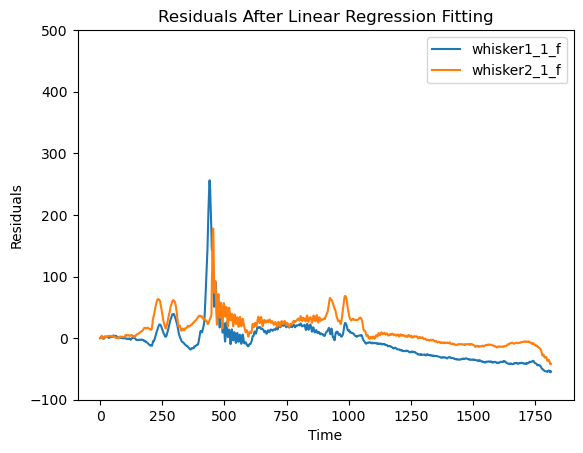

In [4]:
# 1-5
data = pd.read_csv('data/20240902/whisker-20240918T15-06-19.csv')
pressure = data.iloc[0:, 1:7].values
# laser = data.iloc[2:, -1].values
# yaw = data.iloc[2:, -3].values
# position=data.iloc[2:,1:4].values
# velocity=data.iloc[2:,4:7].values
# laser1=laser+25*np.tan(np.radians(yaw-30))
# laser2=laser-25*np.tan(np.radians(yaw-30))
# laser1 = np.where(laser1 > 218, 0, 218 - laser1)
# laser2 = np.where(laser2 > 218, 0, 218 - laser2)
# pitch = data.iloc[2:, -2].values
# point1 = [-0.255186, 1.189175]
# point2 = [-1.104007, 1.177670]
# line_intersection = LineIntersection()
# GT = line_intersection.calculate_GT(point1, point2, [position[:,1],position[:,0]], yaw)
# # GT=((1.188-position[:,0])/np.cos(np.radians(yaw))-0.016)*1000
# GT1=GT+25*np.tan(np.radians(yaw))
# GT2=GT-25*np.tan(np.radians(yaw))
# GT1 = np.where(GT1 > 218, 0, 218 - GT1)
# GT2 = np.where(GT2 > 218, 0, 218 - GT2)
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,1,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
# plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
# plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
# plt.plot(pitch, label="Pitch")
# plt.plot(yaw, label="yaw")
# plt.plot(laser, label="Laser")
# plt.plot(GT, label="GT")
# plt.plot(GT1, label="GT1")
# plt.plot(GT2, label="GT2")
# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
# plt.plot(position[:,0], label="x")
# plt.plot(position[:,1], label="y")
# plt.plot(position[:,2], label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()


# new_data = pd.DataFrame({
#     'whisker1_1': filtered_pressure[:,0],
#     'whisker1_2': filtered_pressure[:,1],
#     'whisker1_3': filtered_pressure[:,2],
#     'whisker2_1': filtered_pressure[:,3],
#     'whisker2_2': filtered_pressure[:,4],
#     'whisker2_3': filtered_pressure[:,5],
#     'Laser1': laser1,
#     'Laser2': laser2,
#     'laser': laser,
#     'yaw': yaw,
#     'pitch': pitch,
#     'positionX': position[:,0],
#     'positionY': position[:,1],
#     'positionZ': position[:,2],
#     'velocityX': velocity[:,0],
#     'velocityY': velocity[:,1],
#     'velocityZ': velocity[:,2],
#     'GT': GT,
#     'GT1': GT1,
#     'GT2': GT2

# })


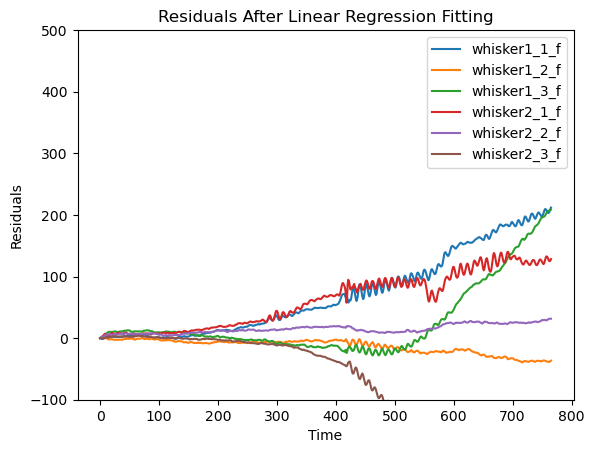

In [5]:
# 1-5
data = pd.read_csv('data/20240902/whisker-20240918T13-28-20.csv')
pressure = data.iloc[0:, 1:7].values
# laser = data.iloc[2:, -1].values
# yaw = data.iloc[2:, -3].values
# position=data.iloc[2:,1:4].values
# velocity=data.iloc[2:,4:7].values
# laser1=laser+25*np.tan(np.radians(yaw-30))
# laser2=laser-25*np.tan(np.radians(yaw-30))
# laser1 = np.where(laser1 > 218, 0, 218 - laser1)
# laser2 = np.where(laser2 > 218, 0, 218 - laser2)
# pitch = data.iloc[2:, -2].values
# point1 = [-0.255186, 1.189175]
# point2 = [-1.104007, 1.177670]
# line_intersection = LineIntersection()
# GT = line_intersection.calculate_GT(point1, point2, [position[:,1],position[:,0]], yaw)
# # GT=((1.188-position[:,0])/np.cos(np.radians(yaw))-0.016)*1000
# GT1=GT+25*np.tan(np.radians(yaw))
# GT2=GT-25*np.tan(np.radians(yaw))
# GT1 = np.where(GT1 > 218, 0, 218 - GT1)
# GT2 = np.where(GT2 > 218, 0, 218 - GT2)
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression2()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.0000005,1,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
# plt.plot(pitch, label="Pitch")
# plt.plot(yaw, label="yaw")
# plt.plot(laser, label="Laser")
# plt.plot(GT, label="GT")
# plt.plot(GT1, label="GT1")
# plt.plot(GT2, label="GT2")
# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
# plt.plot(position[:,0], label="x")
# plt.plot(position[:,1], label="y")
# plt.plot(position[:,2], label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()


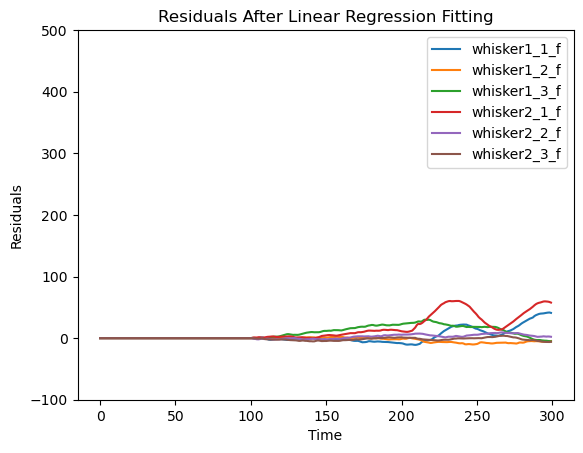

ValueError: All arrays must be of the same length

In [6]:
# 1-5
data = pd.read_csv('data/20240902/app-20240918T15-06-17.csv')
pressure = data.iloc[0:, 1:7].values
# laser = data.iloc[2:, -1].values
# yaw = data.iloc[2:, -3].values
# position=data.iloc[2:,1:4].values
# velocity=data.iloc[2:,4:7].values
# laser1=laser+25*np.tan(np.radians(yaw-30))
# laser2=laser-25*np.tan(np.radians(yaw-30))
# laser1 = np.where(laser1 > 218, 0, 218 - laser1)
# laser2 = np.where(laser2 > 218, 0, 218 - laser2)
# pitch = data.iloc[2:, -2].values
# point1 = [-0.255186, 1.189175]
# point2 = [-1.104007, 1.177670]
# line_intersection = LineIntersection()
# GT = line_intersection.calculate_GT(point1, point2, [position[:,1],position[:,0]], yaw)
# # GT=((1.188-position[:,0])/np.cos(np.radians(yaw))-0.016)*1000
# GT1=GT+25*np.tan(np.radians(yaw))
# GT2=GT-25*np.tan(np.radians(yaw))
# GT1 = np.where(GT1 > 218, 0, 218 - GT1)
# GT2 = np.where(GT2 > 218, 0, 218 - GT2)
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,3,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(pressure[:300, 0] , label=f"whisker1_1_f")
plt.plot(pressure[:300, 1] , label=f"whisker1_2_f")
plt.plot(pressure[:300, 2] , label=f"whisker1_3_f")
plt.plot(pressure[:300, 3] , label=f"whisker2_1_f")
plt.plot(pressure[:300, 4] , label=f"whisker2_2_f")
plt.plot(pressure[:300, 5] , label=f"whisker2_3_f")
# 绘制其他数据
# plt.plot(pitch, label="Pitch")
# plt.plot(yaw, label="yaw")
# plt.plot(laser, label="Laser")
# plt.plot(GT, label="GT")
# plt.plot(GT1, label="GT1")
# plt.plot(GT2, label="GT2")
# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
# plt.plot(position[:,0], label="x")
# plt.plot(position[:,1], label="y")
# plt.plot(position[:,2], label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()


new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'Laser1': laser1,
    'Laser2': laser2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2],
    'GT': GT,
    'GT1': GT1,
    'GT2': GT2

})

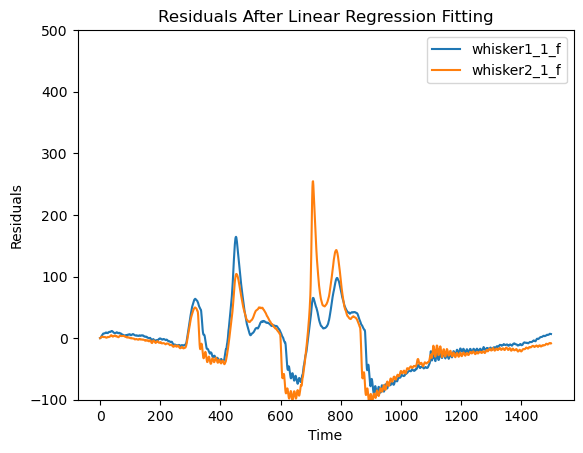

In [20]:
# 1-5
data = pd.read_csv('data/20240919/2024-09-26+19:49:15+.csv')
pressure = data.iloc[500:2000, 7:13].values
# laser = data.iloc[2:, -1].values
# yaw = data.iloc[2:, -3].values
# position=data.iloc[2:,1:4].values
# velocity=data.iloc[2:,4:7].values
# laser1=laser+25*np.tan(np.radians(yaw-30))
# laser2=laser-25*np.tan(np.radians(yaw-30))
# laser1 = np.where(laser1 > 218, 0, 218 - laser1)
# laser2 = np.where(laser2 > 218, 0, 218 - laser2)
# pitch = data.iloc[2:, -2].values
# point1 = [-0.255186, 1.189175]
# point2 = [-1.104007, 1.177670]
# line_intersection = LineIntersection()
# GT = line_intersection.calculate_GT(point1, point2, [position[:,1],position[:,0]], yaw)
# # GT=((1.188-position[:,0])/np.cos(np.radians(yaw))-0.016)*1000
# GT1=GT+25*np.tan(np.radians(yaw))
# GT2=GT-25*np.tan(np.radians(yaw))
# GT1 = np.where(GT1 > 218, 0, 218 - GT1)
# GT2 = np.where(GT2 > 218, 0, 218 - GT2)
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,1,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
# plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
# plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
# plt.plot(pitch, label="Pitch")
# plt.plot(yaw, label="yaw")
# plt.plot(laser, label="Laser")
# plt.plot(GT, label="GT")
# plt.plot(GT1, label="GT1")
# plt.plot(GT2, label="GT2")
# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
# plt.plot(position[:,0], label="x")
# plt.plot(position[:,1], label="y")
# plt.plot(position[:,2], label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

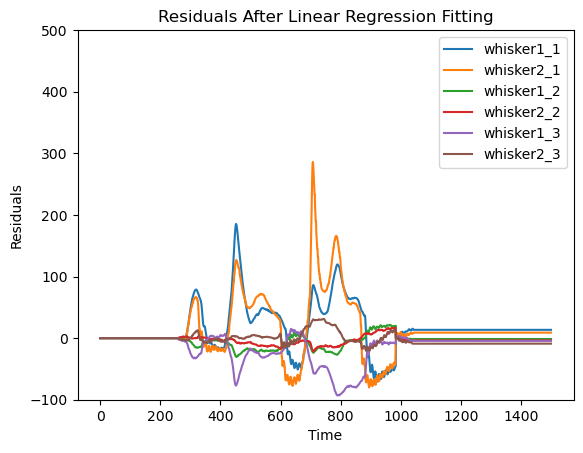

In [18]:
# 1-5
data = pd.read_csv('data/20240919/2024-09-26+19:49:15+.csv')
data1 = data.iloc[500:2000, 13].values
data2 = data.iloc[500:2000, 16].values
data3 = data.iloc[500:2000, 14].values
data4 = data.iloc[500:2000, 17].values
data5 = data.iloc[500:2000, 15].values
data6 = data.iloc[500:2000, 18].values
data6 = data.iloc[500:2000, 18].values
# data7 = data.iloc[:, -1].values

plt.plot(data1, label="whisker1_1")
plt.plot(data2, label="whisker2_1")
plt.plot(data3, label="whisker1_2")
plt.plot(data4, label="whisker2_2")
plt.plot(data5, label="whisker1_3")
plt.plot(data6, label="whisker2_3")
# plt.plot(data7, label="laser")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()


(1250, 2)
[array([[13.08594465]]), array([[12.00478367]]), array([[11.95628553]]), array([[11.22375264]]), array([[11.47657844]]), array([[11.43211333]]), array([[10.95896885]]), array([[10.71643273]]), array([[10.91810373]]), array([[10.53779378]]), array([[9.49150731]]), array([[9.57553854]]), array([[9.87027859]]), array([[9.80415327]]), array([[8.24579848]]), array([[7.97216787]]), array([[8.353202]]), array([[8.50340716]]), array([[7.83721907]]), array([[7.79771734]]), array([[7.17824547]]), array([[7.51697874]]), array([[6.95279486]]), array([[7.11950122]]), array([[7.08657185]]), array([[7.89408734]]), array([[8.26466678]]), array([[7.74851233]]), array([[7.79818574]]), array([[7.92432968]]), array([[7.85562792]]), array([[8.57319134]]), array([[7.32239895]]), array([[8.70277019]]), array([[8.04490451]]), array([[7.65866611]]), array([[8.16462031]]), array([[8.2935429]]), array([[8.30412122]]), array([[8.51538976]]), array([[8.84537552]]), array([[8.98607603]]), array([[9.192987

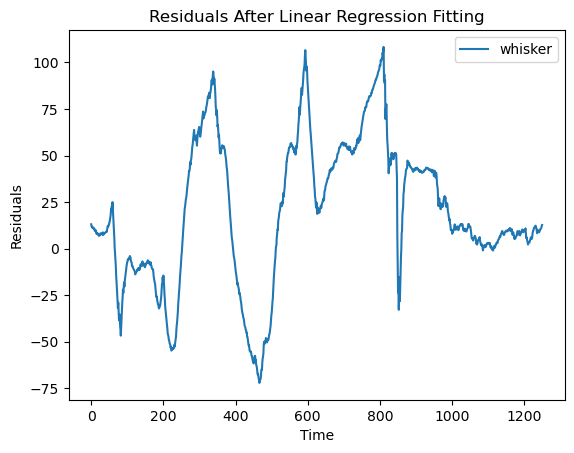

In [12]:
from KF import KalmanFilterFLAT2
def apply_kalman_filterFLAT2(initial_state, initial_position, initial_yaw, test_pre, positions, yaws):
    kf = KalmanFilterFLAT2(initial_state, initial_position, initial_yaw, 0.1, 0.0001, 1)
    estimates = [np.array([initial_state])]
    for z, position, yaw in zip(test_pre[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([234 - z]))
        estimates.append(kf.get_current_estimate())
    return estimates

# initial_covariance = np.array([[0.1]])
# process_noise = np.array([[0.1]])
# measurement_noise = np.array([[1]])

mean_1 = [ 54.20560548, -21.00775578, -14.01101664]
std_1 = [18.14239061,  8.27251843, 11.67656998]

with open('mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_9.0575_whisker1.txt', 'r') as f:
    lines = f.readlines()
    W1_1 = np.array([list(map(float, line.split())) for line in lines[1:33]])
    b1_1 = np.array([list(map(float, line.split())) for line in lines[35:67]]).flatten()
    W2_1 = np.array([list(map(float, line.split())) for line in lines[69:101]])
    b2_1 = np.array([list(map(float, line.split())) for line in lines[103:135]]).flatten()
    W3_1 = np.array([list(map(float, line.split())) for line in lines[137:169]])
    b3_1 = np.array([list(map(float, line.split())) for line in lines[171:203]]).flatten()
    W4_1 = np.array(list(map(float, lines[205].split())))
    b4_1 = np.array(list(map(float, lines[-1].split()))).flatten()

def normalization(data, mean, std):
    normalized_data = (data - mean) / std
    return normalized_data

def relu(x):
    return np.maximum(0, x)

def mlp_inference(input_data, W1, b1, W2, b2, W3, b3, W4, b4):
    # 第一层前向传播
    z1 = np.dot(input_data, W1.T) + b1
    a1 = relu(z1)
    
    # 第二层前向传播
    z2 = np.dot(a1, W2.T) + b2
    a2 = relu(z2)
    
    # 第三层前向传播
    z3 = np.dot(a2, W3.T) + b3
    a3 = relu(z3)
    
    # 输出层前向传播
    output = np.dot(a3, W4.T) + b4
    
    return output

# 1-5
data = pd.read_csv('data/20240919/2024-09-26+19:49:15+.csv')
data1 = data.iloc[750:2000, 13].values
data2 = data.iloc[750:2000, 16].values
data3 = data.iloc[750:2000, 14].values
data4 = data.iloc[750:2000, 17].values
data5 = data.iloc[750:2000, 15].values
data6 = data.iloc[750:2000, 18].values
data7 = data.iloc[750:2000, 1].values
data8 = data.iloc[750:2000, 2].values
data9 = data.iloc[750:2000, -2].values


# 创建线性回归模型
model = CustomLinearRegression()

# # 初始化残差数组
# residuals = np.zeros_like(pressure)

# # 拟合前100个数据点的压力数据
# for i in range(pressure.shape[1]):
#     model.fit(time_steps[0:100], pressure[0:100, i])
#     predicted_pressure = model.predict(time_steps)
#     residuals[:, i] = pressure[:, i] - predicted_pressure

outputs = []
# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

# plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
# plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
# plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
for i in range(len(data2)):
    input_data = np.array([data2[i], data4[i], data6[i]])
    normalized_data = normalization(input_data, mean_1, std_1)
    output = mlp_inference(normalized_data, W1_1, b1_1, W2_1, b2_1, W3_1, b3_1, W4_1, b4_1)
    outputs.append(output)
initial_states = outputs[0]
initial_positions = [data8[0], data7[0]]
initial_yaws = data9[0]
print(np.column_stack((data7, data8)).shape)
test = apply_kalman_filterFLAT2(initial_states, initial_positions, initial_yaws, np.array(outputs), np.column_stack((data8, data7)), np.array(data9))
# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
print(test)
test = np.squeeze(test) 
plt.plot(test, label="whisker")
# plt.plot(position[:,0]*1000 - 400, label="x")
# plt.plot(position[:,1]*100, label="y")
# plt.plot(position[:,2]*100, label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
# plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

(1250, 2)
[array([[13.08594465]]), array([[12.09479032]]), array([[12.18392749]]), array([[11.71992502]]), array([[12.16032913]]), array([[12.28061559]]), array([[12.04124796]]), array([[12.03352984]]), array([[12.36967683]]), array([[12.17659145]]), array([[11.71155957]]), array([[12.55868194]]), array([[13.52935715]]), array([[13.9201427]]), array([[12.94332172]]), array([[12.94307717]]), array([[13.12693809]]), array([[13.12435629]]), array([[12.70981369]]), array([[13.00667926]]), array([[13.00480014]]), array([[13.97665629]]), array([[14.21982895]]), array([[14.98562088]]), array([[15.23355813]]), array([[16.02364185]]), array([[16.34370153]]), array([[15.84920414]]), array([[15.81104189]]), array([[15.82025977]]), array([[15.91228609]]), array([[16.82502334]]), array([[16.05950944]]), array([[17.43016836]]), array([[16.85504832]]), array([[16.65806387]]), array([[17.54751453]]), array([[18.43029888]]), array([[19.39888531]]), array([[20.56093234]]), array([[22.0427585]]), array([

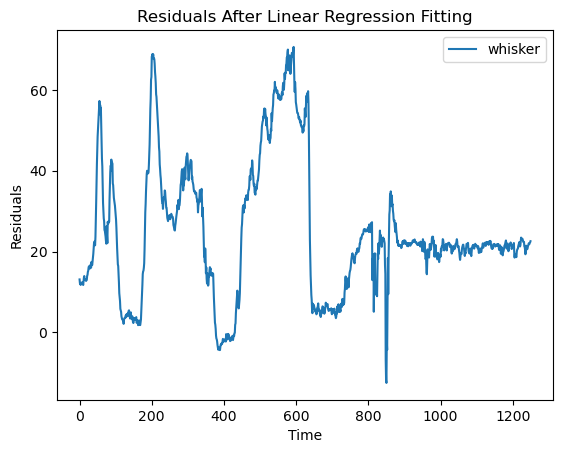

In [13]:
from KF import KalmanFilterFLAT2
def apply_kalman_filterFLAT2(initial_state, initial_position, initial_yaw, test_pre, positions, yaws):
    kf = KalmanFilterFLAT2(initial_state, initial_position, initial_yaw, 0.1, 0.1, 1)
    estimates = [np.array([initial_state])]
    for z, position, yaw in zip(test_pre[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([234 - z]))
        estimates.append(kf.get_current_estimate())
    return estimates

# initial_covariance = np.array([[0.1]])
# process_noise = np.array([[0.1]])
# measurement_noise = np.array([[1]])

mean_1 = [ 54.20560548, -21.00775578, -14.01101664]
std_1 = [18.14239061,  8.27251843, 11.67656998]

with open('mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_9.0575_whisker1.txt', 'r') as f:
    lines = f.readlines()
    W1_1 = np.array([list(map(float, line.split())) for line in lines[1:33]])
    b1_1 = np.array([list(map(float, line.split())) for line in lines[35:67]]).flatten()
    W2_1 = np.array([list(map(float, line.split())) for line in lines[69:101]])
    b2_1 = np.array([list(map(float, line.split())) for line in lines[103:135]]).flatten()
    W3_1 = np.array([list(map(float, line.split())) for line in lines[137:169]])
    b3_1 = np.array([list(map(float, line.split())) for line in lines[171:203]]).flatten()
    W4_1 = np.array(list(map(float, lines[205].split())))
    b4_1 = np.array(list(map(float, lines[-1].split()))).flatten()

def normalization(data, mean, std):
    normalized_data = (data - mean) / std
    return normalized_data

def relu(x):
    return np.maximum(0, x)

def mlp_inference(input_data, W1, b1, W2, b2, W3, b3, W4, b4):
    # 第一层前向传播
    z1 = np.dot(input_data, W1.T) + b1
    a1 = relu(z1)
    
    # 第二层前向传播
    z2 = np.dot(a1, W2.T) + b2
    a2 = relu(z2)
    
    # 第三层前向传播
    z3 = np.dot(a2, W3.T) + b3
    a3 = relu(z3)
    
    # 输出层前向传播
    output = np.dot(a3, W4.T) + b4
    
    return output

# 1-5
data = pd.read_csv('data/20240919/2024-09-26+19:49:15+.csv')
data1 = data.iloc[750:2000, 13].values
data2 = data.iloc[750:2000, 16].values
data3 = data.iloc[750:2000, 14].values
data4 = data.iloc[750:2000, 17].values
data5 = data.iloc[750:2000, 15].values
data6 = data.iloc[750:2000, 18].values
data7 = data.iloc[750:2000, 1].values
data8 = data.iloc[750:2000, 2].values
data9 = data.iloc[750:2000, -2].values


# 创建线性回归模型
model = CustomLinearRegression()

# # 初始化残差数组
# residuals = np.zeros_like(pressure)

# # 拟合前100个数据点的压力数据
# for i in range(pressure.shape[1]):
#     model.fit(time_steps[0:100], pressure[0:100, i])
#     predicted_pressure = model.predict(time_steps)
#     residuals[:, i] = pressure[:, i] - predicted_pressure

outputs = []
# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

# plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
# plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
# plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
for i in range(len(data2)):
    input_data = np.array([data1[i], data3[i], data5[i]])
    normalized_data = normalization(input_data, mean_1, std_1)
    output = mlp_inference(normalized_data, W1_1, b1_1, W2_1, b2_1, W3_1, b3_1, W4_1, b4_1)
    outputs.append(output)
initial_states = outputs[0]
initial_positions = [data8[0], data7[0]]
initial_yaws = data9[0]
print(np.column_stack((data7, data8)).shape)
test = apply_kalman_filterFLAT2(initial_states, initial_positions, initial_yaws, np.array(outputs), np.column_stack((data8, data7)), np.array(data9))
# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
print(test)
test = np.squeeze(test) 
plt.plot(test, label="whisker")
# plt.plot(position[:,0]*1000 - 400, label="x")
# plt.plot(position[:,1]*100, label="y")
# plt.plot(position[:,2]*100, label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
# plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

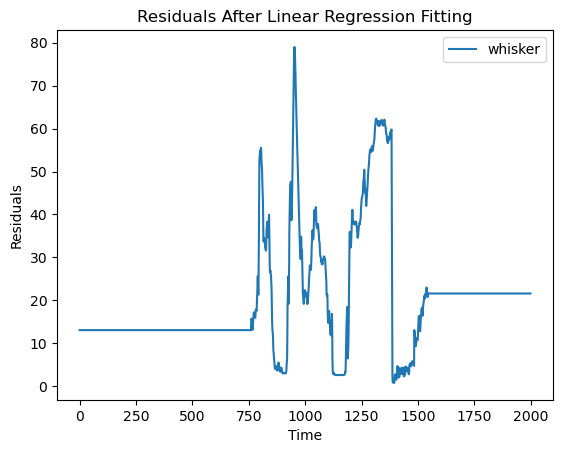

In [39]:
mean_1 = [ 54.20560548, -21.00775578, -14.01101664]
std_1 = [18.14239061,  8.27251843, 11.67656998]

with open('mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_9.0575_whisker1.txt', 'r') as f:
    lines = f.readlines()
    W1_1 = np.array([list(map(float, line.split())) for line in lines[1:33]])
    b1_1 = np.array([list(map(float, line.split())) for line in lines[35:67]]).flatten()
    W2_1 = np.array([list(map(float, line.split())) for line in lines[69:101]])
    b2_1 = np.array([list(map(float, line.split())) for line in lines[103:135]]).flatten()
    W3_1 = np.array([list(map(float, line.split())) for line in lines[137:169]])
    b3_1 = np.array([list(map(float, line.split())) for line in lines[171:203]]).flatten()
    W4_1 = np.array(list(map(float, lines[205].split())))
    b4_1 = np.array(list(map(float, lines[-1].split()))).flatten()

def normalization(data, mean, std):
    normalized_data = (data - mean) / std
    return normalized_data

def relu(x):
    return np.maximum(0, x)

def mlp_inference(input_data, W1, b1, W2, b2, W3, b3, W4, b4):
    # 第一层前向传播
    z1 = np.dot(input_data, W1.T) + b1
    a1 = relu(z1)
    
    # 第二层前向传播
    z2 = np.dot(a1, W2.T) + b2
    a2 = relu(z2)
    
    # 第三层前向传播
    z3 = np.dot(a2, W3.T) + b3
    a3 = relu(z3)
    
    # 输出层前向传播
    output = np.dot(a3, W4.T) + b4
    
    return output

# 1-5
data = pd.read_csv('data/20240919/2024-09-26+19:49:15+.csv')
data1 = data.iloc[:2000, 13].values
data2 = data.iloc[:2000, 16].values
data3 = data.iloc[:2000, 14].values
data4 = data.iloc[:2000, 17].values
data5 = data.iloc[:2000, 15].values
data6 = data.iloc[:2000, 18].values

# 创建线性回归模型
model = CustomLinearRegression()

# # 初始化残差数组
# residuals = np.zeros_like(pressure)

# # 拟合前100个数据点的压力数据
# for i in range(pressure.shape[1]):
#     model.fit(time_steps[0:100], pressure[0:100, i])
#     predicted_pressure = model.predict(time_steps)
#     residuals[:, i] = pressure[:, i] - predicted_pressure

outputs = []
# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

# plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
# plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
# plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
for i in range(len(data2)):
    input_data = np.array([data1[i], data3[i], data5[i]])
    normalized_data = normalization(input_data, mean_1, std_1)
    output = mlp_inference(normalized_data, W1_1, b1_1, W2_1, b2_1, W3_1, b3_1, W4_1, b4_1)
    outputs.append(output)

# plt.plot(laser1, label="laser1")
# plt.plot(laser2, label="laser2")
plt.plot(outputs, label="whisker")
# plt.plot(position[:,0]*1000 - 400, label="x")
# plt.plot(position[:,1]*100, label="y")
# plt.plot(position[:,2]*100, label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
# plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

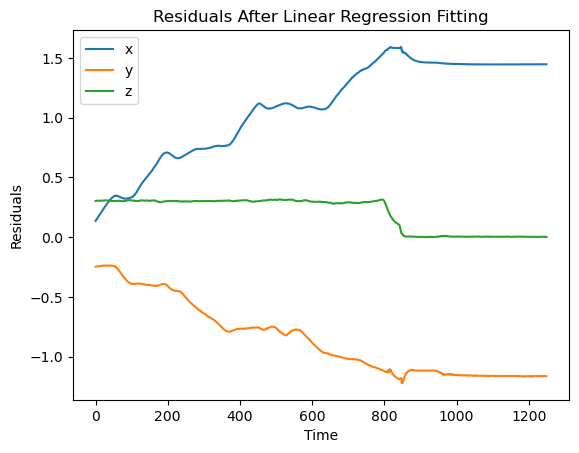

In [17]:
data = pd.read_csv('data/20240919/2024-09-26+19:49:15+.csv')
data1 = data.iloc[750:2000, 1].values
data2 = data.iloc[750:2000, 2].values
data3 = data.iloc[750:2000, 3].values
data4 = data.iloc[750:2000, -2].values


plt.plot(data1, label="x")
plt.plot(data2, label="y")
plt.plot(data3, label="z")
# plt.plot(data4, label="yaw")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
# plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

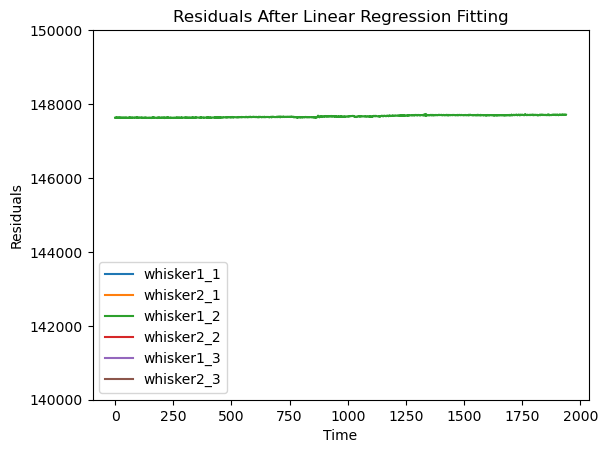

In [13]:
# 1-5
data = pd.read_csv('data/20240919/2024-09-24+13:53:22+.csv')
data1 = data.iloc[:, 1].values
data2 = data.iloc[:, 4].values
data3 = data.iloc[:, 2].values
data4 = data.iloc[:, 5].values
data5 = data.iloc[:, 3].values
data6 = data.iloc[:, 6].values

plt.plot(data1, label="whisker1_1")
plt.plot(data2, label="whisker2_1")
plt.plot(data3, label="whisker1_2")
plt.plot(data4, label="whisker2_2")
plt.plot(data5, label="whisker1_3")
plt.plot(data6, label="whisker2_3")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(140000,150000)
plt.title("Residuals After Linear Regression Fitting")
plt.show()